### Load Repository

In [ ]:
!git clone https://github.com/chipnbits/fashionableODE.git

Cloning into 'fashionableODE'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 20 (delta 2), reused 4 (delta 1), pack-reused 13 (from 2)
Receiving objects: 100% (20/20), 45.84 MiB | 15.42 MiB/s, done.
Resolving deltas: 100% (2/2), done.


### Imports
The primary machine learning library for this demonstration is PyTorch https://pytorch.org/

fashionableODE imports are supporting files found in the file explorer after cloning the repository above.

In [ ]:
import os

import torch
import einops
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import fashionableODE.utils as utils
import fashionableODE.persistence as mdl
from fashionableODE.unet import UNet

### Load Training and Testing Data

Pytorch offers a convenient way to fetch training data sets online via the torchvision.datasets package. Here we fetch a large set of 60,000 labeled training images and 10,000 labeled testing images. The images are 28x28 pixels and are of fashion items.

In [ ]:
def get_mnist(batch_size=64, shuffle=True):
    """Load FashionMNIST dataset with DataLoaders."""
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_loader = DataLoader(
        datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True),
        batch_size=batch_size, shuffle=shuffle
    )
    test_loader = DataLoader(
        datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True),
        batch_size=batch_size, shuffle=False
    )

    return train_loader, test_loader


### Inspect Training Data Batch
A batch of training data is examined. Note that image processing (normalization) has been added to the data loading process, creating a higher contrast in the images. The normalization adjusts the pixel values to be centered about 0, making it easier for the neural network to process the information.

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 174kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.26MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.13MB/s]


images tensor is torch.Size([64, 1, 28, 28])


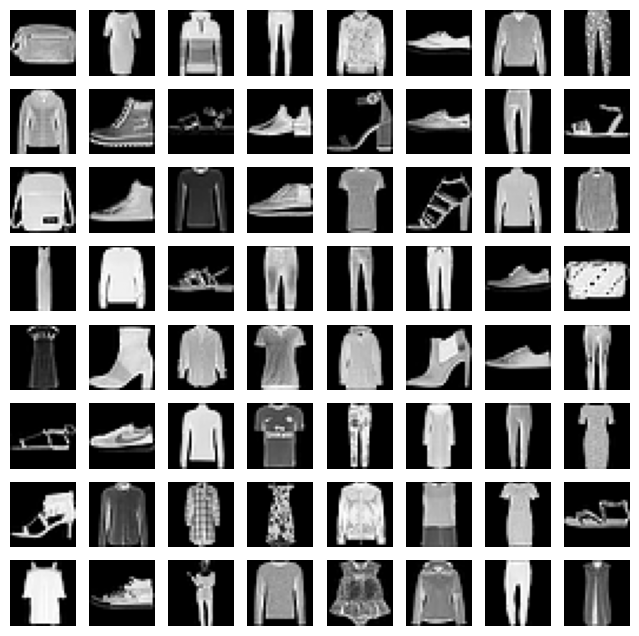

In [ ]:
train_loader, test_loader = get_mnist(batch_size=64, shuffle=True)
utils.show_first_batch(train_loader);

### Define and Train a Simple Model to Approximate a Velocity Flow Field

The objective is to approximate a time-dependent velocity field that forms a map between images of pure Gaussian noise $x_0 \sim \mathcal{N}(0,I)$ and images from the dataset $x_1$. We effectively learn some function $\dot x = y(x_t,t ; \theta)$ where $x_t$ is some image at time $t$, between $t=0$ pure noise and $t=1$ nice images, and $\theta$ are the parameters of the approximating function $y$. In practice a neural network using covolutions and a Unet structure is used to "learn" function $y$ from the data. Below is a training loop to learn the time dependent velocity field.

### Training Phase (Implementation of Stochastic Interpolation)

In [ ]:
def train(model: UNet, dataloader, num_epochs=5, optimizer=None, device='cuda'):
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        # Set learning rate scheduler

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.96)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0
        progress = tqdm(
            enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}"
        )
        for i, data in progress:
            # Gather interpolated samples and velocities
            X1, labels = data
            X1 = X1.to(device)
            X0 = torch.randn_like(X1).to(device)
            T = torch.rand(X1.size(0)).to(device)
            T_expanded = T.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            XT = (1 - T_expanded) * X0 + T_expanded * X1
            BT = X1 - X0

            # Predict the correct velocities with time embedding
            optimizer.zero_grad()
            B_hat_T = model(XT, T)
            # Compute the loss
            loss = torch.mean((BT - B_hat_T) ** 2) / torch.mean(BT ** 2)

            loss.backward()
            # Gradient clipping for DNN
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            # Update progress bar with the current average loss
            progress.set_postfix(loss=running_loss / (i + 1), lr=optimizer.param_groups[0]['lr'])

        scheduler.step()

        if epoch % 10 == 0:
            # save model at end of train
            cur_dir = os.getcwd()
            save_path = os.path.join(cur_dir, f"unet_{epoch}epochs.pth")
            mdl.save_model(model, save_path)

Optionally retrain a new mode. Try requesting a GPU runtime if doing retraining using the `Runtime` menu above.

In [ ]:
# Check if retraining desired (takes 15mins with a GPU instance)
retrain_model=False

if retrain_model:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")
  model = UNet(n_channels=1, out_channels=1, dim=64, mults=[1,2,4,8])
  model.to(device)
  train(model, train_loader, num_epochs = 35, device=device)

**Optional:** A more sophisticated Unet with attention layers

In [ ]:
from fashionableODE.unet_attn import Unet2D

model_params = {
    'dim'              : 16,             # Base number of hidden channels in model
    'dim_mults'        : (1, 2,2),      # Multipliers for hidden dims in each superblock, total 2x downsamples = len(dim_mults)-1
    'data_channels'    : 1,              # Data clamped down to 22 channels -1 to 20, with -1 "sky/air" category
    'dropout'          : 0.,              # Optional network dropout
    'self_condition'   : False,           # Optional conditioning on input data
    'time_resolution'  : 128,             # Resolution of time (number of random Fourier features)
    'time_bandwidth'   : 1000.,            # Starting bandwidth of fourier frequencies, f ~ N(0, time_bandwidth)
    'time_learned_emb' : True,            # Learnable fourier freqs and phases

    'attn_enabled'     : True,            # Enable or disable self attention before each (down/up sample) also feeds skip connections
    'attn_dim_head'    : 32,              # Size of attention hidden dimension heads
    'attn_heads'       : 2,               # Number of chunks to split hidden dimension into for attention
    'full_attn'        : None,            # defaults to full attention only for inner most layer final down, middle, first up
    'flash_attn'       : False            # For high performance GPUs https://github.com/Dao-AILab/flash-attention
}

train_attn_unet = False

if train_attn_unet:
  # Create a U-Net model
  model = Unet2D(**model_params)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")
  model.to(device)
  train(model, train_loader, num_epochs = 50, device=device)


### Inference via Solution to ODE

With a model trained we can load its weights and generate images from pure noise via ODE integration.

In [ ]:
model = UNet(n_channels=1, out_channels=1, dim=64, mults=[1,2,4,8])
model = mdl.load_model(model, "./fashionableODE/unet_35epochs.pth",device='cpu')

Loaded model from ./fashionableODE/unet_35epochs.pth


RK4 Method:

$$
y_{n+1} = y_n + \frac{h}{6} \left( k_1 + 2k_2 + 2k_3 + k_4 \right),
\quad t_{n+1} = t_n + h,
$$

$$
k_1 = f(t_n, y_n),
$$

$$
k_2 = f\left(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_1\right),
$$

$$
k_3 = f\left(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_2\right),
$$

$$
k_4 = f\left(t_n + h, y_n + hk_3\right).
$$

Euler Method:

$$
y_{n+1} = y_n + h f(t_n, y_n),
\quad t_{n+1} = t_n + h,
$$


In [ ]:
# A collection of solver methods to perform ODE integration
def euler_method(dxdt, xt, t, dt):
    return xt + dxdt(xt, t) * dt

def rk4_method(dxdt, xt, t, dt):
    k1 = dxdt(xt, t)
    k2 = dxdt(xt + 0.5 * dt * k1, t + 0.5 * dt)
    k3 = dxdt(xt + 0.5 * dt * k2, t + 0.5 * dt)
    k4 = dxdt(xt + dt * k3, t + dt)
    return xt + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

# generative AI with learned model dxdt, a numerical solver, and number of steps
def generate_images(dxdt, solver_method, x0, t_start=0, t_end=1, num_steps=20):

    dt = (t_end - t_start) / num_steps
    t = torch.linspace(t_start, t_end, num_steps, device=x0.device)
    x = x0

    # Store the trajectory
    trajectory = [x0]
    with tqdm(total=num_steps - 1, desc="Integrating", unit="step") as pbar:
        for i in range(num_steps - 1):
            ti = t[i].unsqueeze(0)
            x_next = solver_method(dxdt, x, ti, dt)
            trajectory.append(x_next)
            x = x_next
            pbar.update(1)

    return torch.stack(trajectory, dim=0)


Integrating: 100%|██████████| 19/19 [00:04<00:00,  4.24step/s]


images tensor is torch.Size([16, 1, 28, 28])


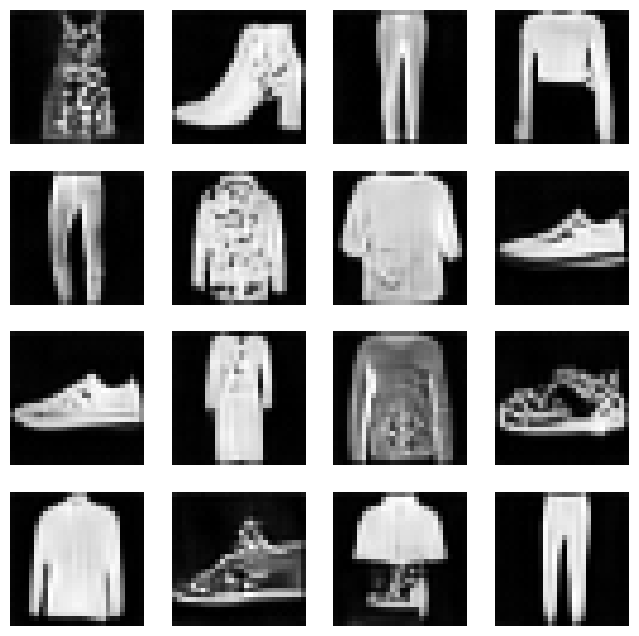

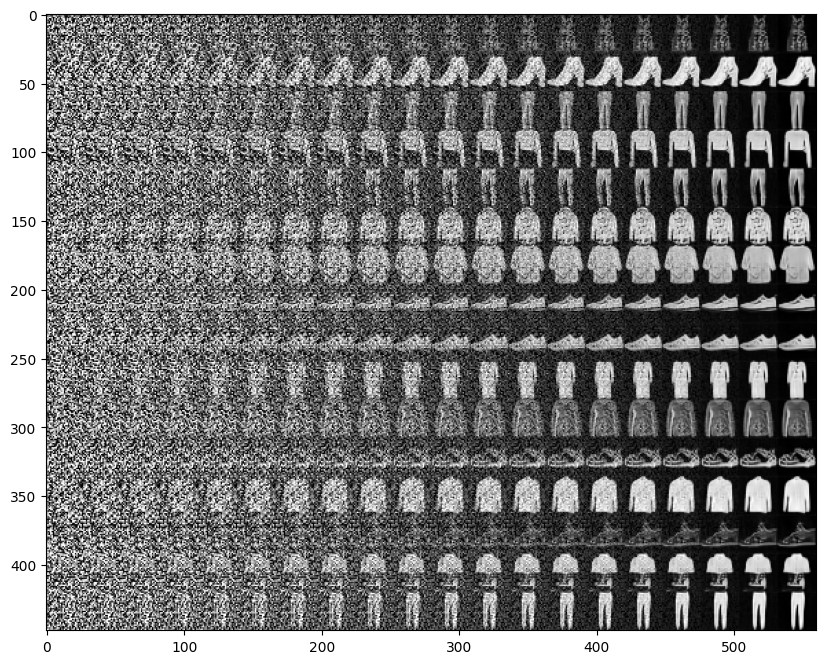

In [ ]:
import time

def dxdt(x,t):
    return model(x, t)

# Integrate the learned dynamics from t =0 to t=1 with initial condition x0
X0 = torch.randn(16,1,28,28)

Xint_euler = generate_images(dxdt, euler_method, X0, 0, 1, 20)

final_frame = Xint_euler[-1].detach()
utils.show_images(final_frame, denormalize=True)
utils.show_time_series(Xint_euler, denormalize=True)


In [ ]:
# compute using RK4 and compare the errors
Xint_rk4 = generate_images(dxdt, rk4_method, X0, 0, 1, 20)
error_diff = Xint_euler - Xint_rk4

Integrating: 100%|██████████| 19/19 [00:18<00:00,  1.02step/s]


images tensor is torch.Size([16, 1, 28, 28])


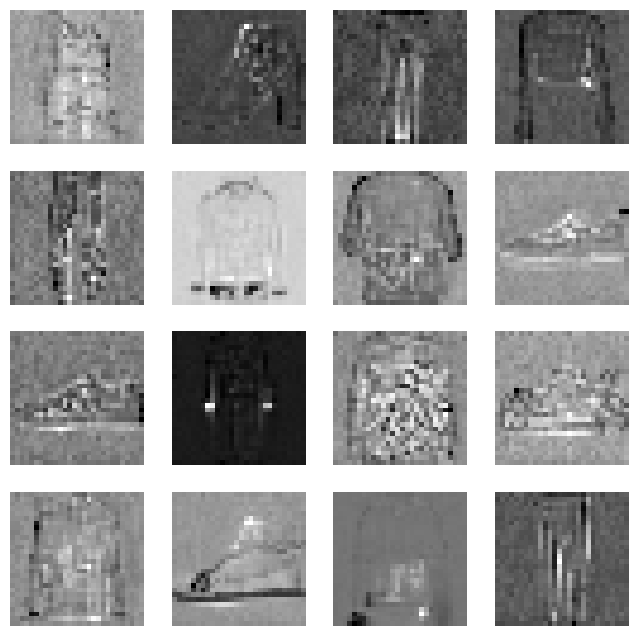

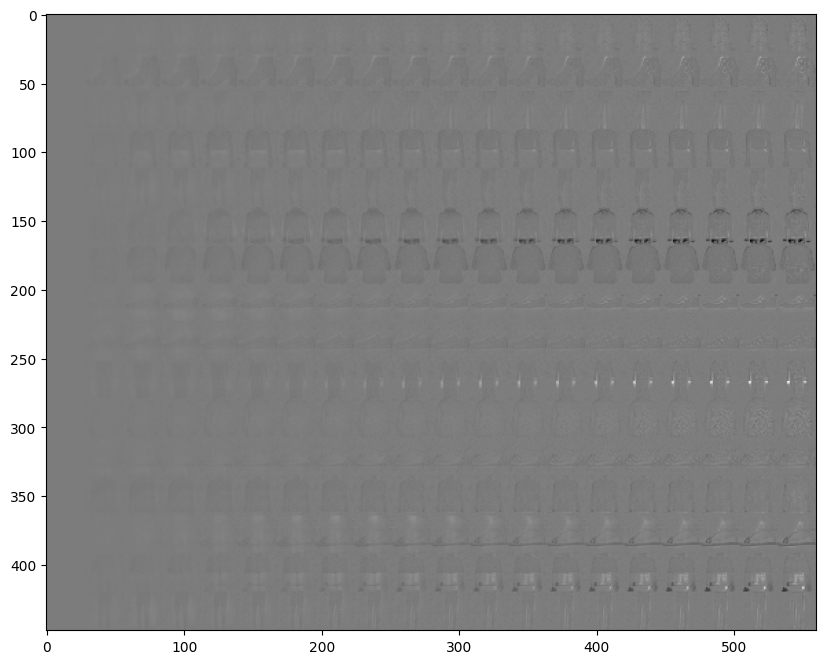

In [ ]:
utils.show_images(error_diff[-1].detach(), denormalize=False)
utils.show_time_series(error_diff, denormalize=False)

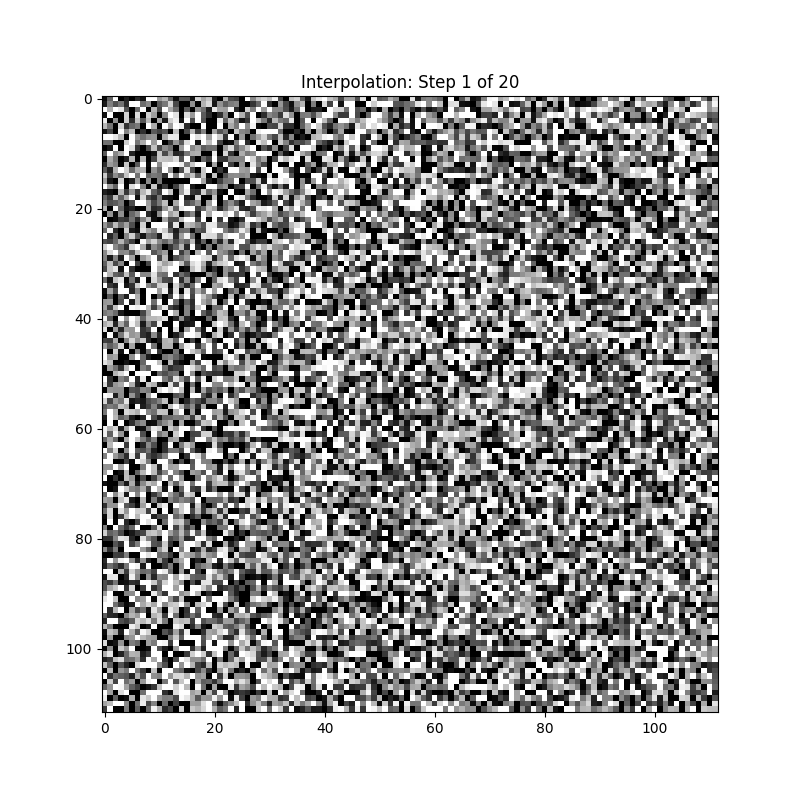

In [ ]:
#Playback gif
from IPython.display import Image

generated_images = Xint_rk4.detach().cpu()
utils.animate_batch(generated_images, fps=5, save_path = "./diffusion_process.gif", denormalize = True)

Image(open("./diffusion_process.gif",'rb').read())